# Socc HAR - Training

Run the following cells to...
 * train or re-train a classifier with the SOCC-HAR-32 Datasets
 * re-evaluate a given classifier

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## 0. Setup

this step will...
  * fetch the source code
  * mount the video data to the VM
  * install the dependencies

You can follow the instruction in section **Colab** *or* in section **GCP** depending on the platform you are using right now!

### Colab

👉 first of all you need to access the socc-har-toolkit repository. Therefore you need to upload your private SSH-Key. By running the following cell an upload promp will be shown. This is where your need to upload your SSH-Key!

In [2]:
from google.colab import files
from pathlib import Path

uploaded = files.upload()

for filename in uploaded.keys():
  Path(filename).rename('id_rsa')
  assert Path('id_rsa').exists(), 'upload failed'

Saving id_rsa to id_rsa


In [3]:
%env SSH_KEY=/content/id_rsa
! chmod 400 $SSH_KEY
! GIT_SSH_COMMAND='ssh -i $SSH_KEY -o StrictHostKeyChecking=no -o IdentitiesOnly=yes' git clone git@gitlab.com:socc-har/socc-har-toolkit.git

env: SSH_KEY=/content/id_rsa
Cloning into 'socc-har-toolkit'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 495 (delta 87), reused 126 (delta 61), pack-reused 336
Receiving objects: 100% (495/495), 7.31 MiB | 5.01 MiB/s, done.
Resolving deltas: 100% (289/289), done.


In [4]:
assert Path('socc-har-toolkit').exists(), 'cloning the repository failed'

👉 Now you need to mount your whole Drive Storage to the VM by following the upcoming dialog:

In [6]:
from google.colab import drive
drive.mount('/content/drive')
assert Path('/content/drive').exists()

Mounted at /content/drive


⚠️ you can skip this step if you already did it **once**!

👉 you need to mount the video data stored in Google Drive to `socc-har-toolkit/data`.
Therefore you might got a public link to the content, which will navigate you to the `SOCC_HAR-32`-folder in Google Drive. Tap the folder and choose option `Add a shortcut to Drive` (like on the screenshot below) and link it to your personal Drive storage.

<style>img { width: 20px; }
</style>

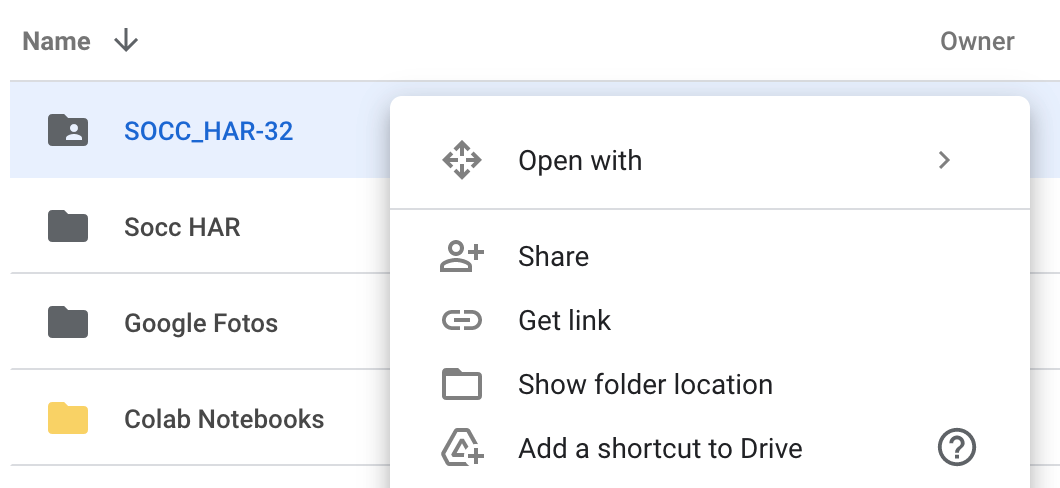

Your personal Drive Storage now is mounted to this VM, as you can see on the left-hand 'files'-tab in Colab under `/drive/MyDrive/` (see screenshot below)


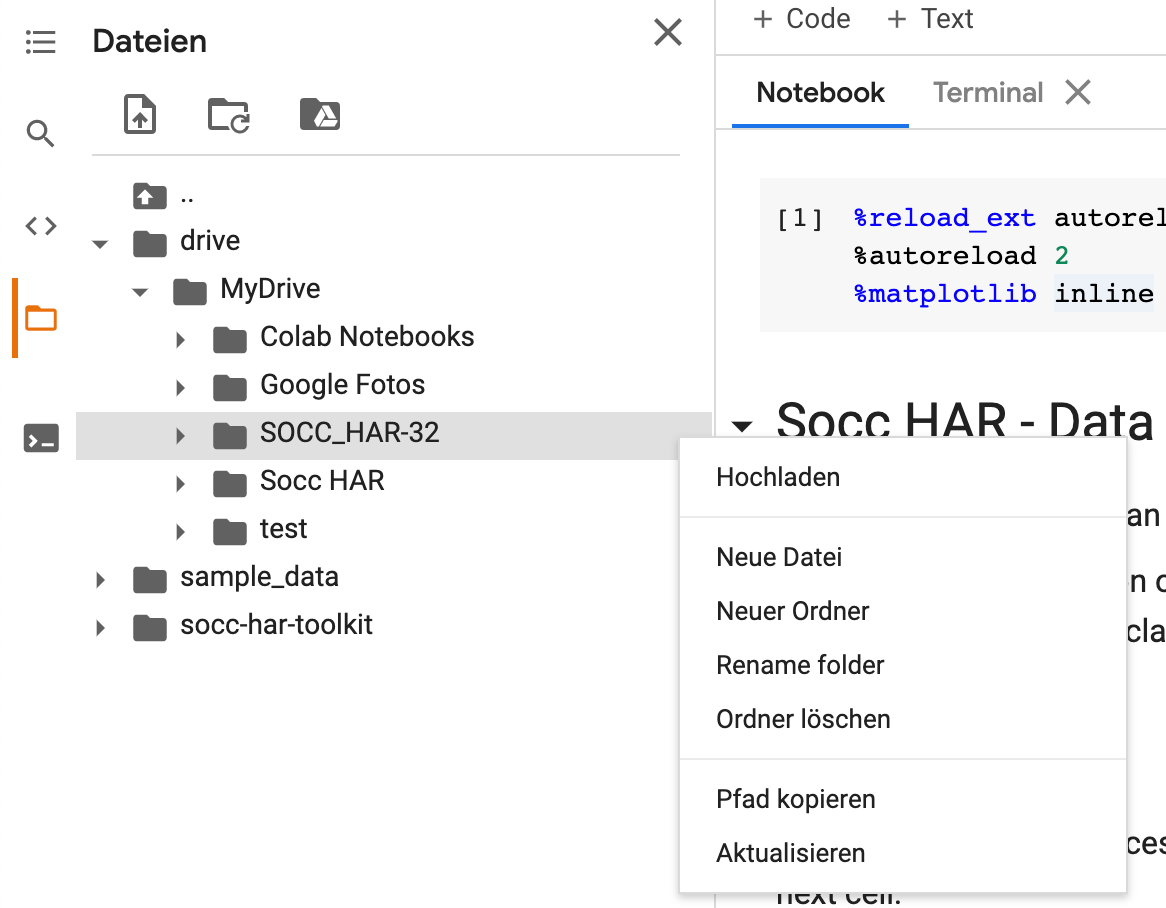

👉 Navigate to the SOCC_HAR-32-folder in the files tab (like in the screenshot above) and copy the path within the context menu shown in the above screenshot (`Pfad kopieren`). Then paste it into the following form under `data_mount_path` and run the cell

In [7]:
import re

data_mount_path = "/content/drive/MyDrive/SOCC_HAR-32" #@param {type:"string"}

match = re.match(r'^\/content\/drive\/MyDrive\/.*SOCC_HAR-32\/?$', data_mount_path)
assert bool(match), 'path should start with /content/drive/MyDrive and ends with the folder name of SOCC_HAR-32'

In [8]:
%env MOUNT_PATH=$data_mount_path

env: MOUNT_PATH=/content/drive/MyDrive/SOCC_HAR-32


⚠️ please run only **one** of the following code cells:

* **Option 1**: mounting video data (fast, but may slow down training time)
* **Option 2**: copying video data (this might take up to an hour, but improves training speed if you train a lot of epochs)

Option 1:

In [9]:
! mkdir /content/socc-har-toolkit/data
! ln -s $MOUNT_PATH/* /content/socc-har-toolkit/data

mkdir: cannot create directory ‘/content/socc-har-toolkit/data’: File exists


Option 2:

In [11]:
! mkdir /content/socc-har-toolkit/data
! rsync -r --info=progress2 "$MOUNT_PATH/video/youtube" /content/socc-har-toolkit/data/video
! rsync -r --info=progress2 "$MOUNT_PATH/video/drive" /content/socc-har-toolkit/data/video

 47,622,673,701 100%   38.09MB/s    0:19:52 (xfr#131, to-chk=0/261)
 24,266,045,771 100%   38.21MB/s    0:10:05 (xfr#68, to-chk=0/137)


Now the content of `SOCC_HAR-32` should also appear in `socc-har-toolkit/data`

In [10]:
assert Path('/content/socc-har-toolkit/data/video/youtube').exists(), 'Your mount may exists, but is invalid'

In [11]:
%cd /content/socc-har-toolkit
! GIT_SSH_COMMAND='ssh -i $SSH_KEY -o StrictHostKeyChecking=no -o IdentitiesOnly=yes' git fetch
! GIT_SSH_COMMAND='ssh -i $SSH_KEY -o StrictHostKeyChecking=no -o IdentitiesOnly=yes' git reset --hard origin/feature/relabel

/content/socc-har-toolkit
HEAD is now at 8d8a038 Bugfix: GoalKick Action in Goal-Search results


### GCP

In [ ]:
! gcsfuse soccer-action-classification-data /home/jupyter/socc-har-toolkit/data

### Install dependencies

finally install all needed dependencies:

In [12]:
! pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
! pip install pytorch_lightning==1.0.8
! pip install av
! pip install matplotlib
! pip install git+https://gitlab.com/obuilds/public/pytube@ob-v1 # fork of pytube3
! pip install -U --no-cache-dir gdown --pre
! pip install comet_ml
! pip install celluloid
! pip install mmaction2==0.9.0
! pip install mmcv
! pip install decord

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 563kB 12.7MB/s 
     |████████████████████████████████| 829kB 28.1MB/s 
     |████████████████████████████████| 276kB 46.7MB/s 
     |████████████████████████████████| 102kB 7.0MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=2cf29011173c39486127ebc9c7744ce2324782d245ed6e9142676cd3b5a6b819
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44620 sha256=13a71c99c8399972c10417f152002cf1290874bdf2d1b0f9a241fe6c53807f67
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built future PyYAML
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
  Found existing installa

In [13]:
import torch
assert torch.cuda.is_available()
%cd /content/socc-har-toolkit/

/content/socc-har-toolkit


## 1. Pick an (pre-trained) experiment

In [14]:
from src.data import MediaDir, DatabaseHandle, DataModule
from src.util.storage import Storage, StoredExperiment, benchmarks
from src.eval import EvaluationModule
from src.eval.database_transactions import Transactions
from src.eval.widgets.relabeler import Relabeler
from src.train import TrainLogger
import torch
import pandas as pd
from src.util import storage

/usr/local/lib/python3.6/dist-packages/mmcv/utils/registry.py:64: UserWarning: The old API of register_module(module, force=False) is deprecated and will be removed, please use the new API register_module(name=None, force=False, module=None) instead.
  'The old API of register_module(module, force=False) '
/usr/local/lib/python3.6/dist-packages/mmaction/models/backbones/resnet_tin.py:12: UserWarning: Please install mmcv-full to support "tin_shift"
  warnings.warn('Please install mmcv-full to support "tin_shift"')


In [16]:
storage = Storage()
storage.widget()

In [17]:
exp = StoredExperiment(storage.experiment_path)

pretrained_path = exp.get_checkpoints()
report_path = exp.get_report()
print(pretrained_path)
print(report_path)

download ckpt from narendorf/soccar-32-ph1/a009a640232646bc970d832bbf1a8063
download report from narendorf/soccar-32-ph1/a009a640232646bc970d832bbf1a8063
narendorf_soccar-32-ph1_a009a640232646bc970d832bbf1a8063.ckpt
narendorf_soccar-32-ph1_a009a640232646bc970d832bbf1a8063.csv


Hyperparameter:

In [18]:
hparams = torch.load(pretrained_path, map_location=torch.device('cpu'))['hyper_parameters']
hparams

{'accumulate_grad_batches': 8,
 'batch_size': 11,
 'consensus': 'max',
 'epochs': 10,
 'fps': 6,
 'lr': [3e-06, 0.003],
 'mean': [0.37409, 0.44932, 0.30282],
 'name': 'irCSN_152',
 'num_frames': 24,
 'optim': 'adam',
 'pretrained_path': PosixPath('narendorf_soccar-32-ph0_9a7c4b4803de43a7b15b3678cd32e3c0.ckpt'),
 'res': 224,
 'scheduler': 'cycle',
 'std': [0.01051, 0.01055, 0.01259],
 'trainable_groups': 4,
 'weight_decay': 0.0001}

## 1. Initialize Data Module

In [19]:
from src.data import MediaDir, DatabaseHandle, DataStats, DataModule
from src.eval import EvaluationModule, Plotter
from src.util.storage import Storage
from src.train import TrainLogger, Classifier

In [20]:
#@title Storage
dataset = "socc-har-32-v1.1" #@param ["socc-har-32-v1", "socc-har-32-v1.1"]

data_path = "./data"
out_path = "./data/out" #@param {type:"string"}
metadata_path = "/content/drive/MyDrive/SOCC_HAR-32/video_metadata/colab.pt" #@param {type:"string"}



In [21]:
torch.load('/content/drive/MyDrive/SOCC_HAR-32/video_metadata/colab.pt')['train']['video_paths']

['/content/drive/My Drive/SOCC_HAR-32/video/youtube/U8AcLO8xmkg/360p.mp4',
 '/content/drive/My Drive/SOCC_HAR-32/video/youtube/-mEuS_q-r7I/360p.mp4',
 '/content/drive/My Drive/SOCC_HAR-32/video/youtube/Q0DpbHOnvsw/360p.mp4',
 '/content/drive/My Drive/SOCC_HAR-32/video/youtube/usCY3FW9hOA/360p.mp4',
 '/content/drive/My Drive/SOCC_HAR-32/video/youtube/lY4q-6afMyg/360p.mp4',
 '/content/drive/My Drive/SOCC_HAR-32/video/youtube/yXMDdSZNniI/360p.mp4',
 '/content/drive/My Drive/SOCC_HAR-32/video/youtube/rH_1-8KVmLk/360p.mp4',
 '/content/drive/My Drive/SOCC_HAR-32/video/youtube/-Ma5kKs1otY/360p.mp4',
 '/content/drive/My Drive/SOCC_HAR-32/video/youtube/ID-_RMs7vIg/360p.mp4',
 '/content/drive/My Drive/SOCC_HAR-32/video/youtube/1xfUCTAoU5k/360p.mp4',
 '/content/drive/My Drive/SOCC_HAR-32/video/youtube/kmwhnbiWhzI/360p.mp4',
 '/content/drive/My Drive/SOCC_HAR-32/video/youtube/wMMJ6H4e9AM/360p.mp4',
 '/content/drive/My Drive/SOCC_HAR-32/video/youtube/gsEhBSS1UHw/360p.mp4',
 '/content/drive/My Drive

In [22]:
#@title Sampling

fps = 6 #@param {type: "slider", min:5, max:25, step: 1}
num_frames = 24 #@param {type:"slider", min:8, max:64, step:8}
res = 224 #@param {type:"slider", min:112, max:312, step:16}
max_train_samples_per_class = 200 #@param {type:"slider", min:10, max:1000, step:5}
num_workers = 12 #@param {type:"slider", min:4, max:16, step:4}

f'duration of clips: {num_frames/fps:.2f} sec'

'duration of clips: 4.00 sec'

**Todo**: Dropdown Widget with all exps

In [23]:
#@title Pre-trained models
new = False #@param {type:"boolean"}


**Todo**: store report in out_dir! each epoch!

In [24]:
#@title Architecture
from src.arch import C3D, irCSN_152, R2Plus1D_34, SlowFast4x16_50, SlowFast8x8_50
from src.arch.x3d import X3D_S, X3D_M

arch = irCSN_152 #@param ["C3D", "irCSN_152", "R2Plus1D_34", "SlowFast4x16_50", "SlowFast8x8_50", "X3D_S", "X3D_M"] {type:"raw"}
arch = arch(num_classes=32)

In [25]:
#@title Storage

project = "narendorf/soccar-32" #@param ['narendorf/soccar-32']
phase = "Ph1" #@param ["Ph0", "Ph1", "Ph2"]

In [26]:
#@title Classifier

epochs = 10 #@param {type:"slider", min:1, max:100, step:1}
weight_decay = 1.0E-4 #@param {type:"number"}
optim = "adam" #@param ["adam", "sgd"]
scheduler = "cycle" #@param ["cosine", "cycle", "plateau"]
consensus = "max" #@param ["avg", "max"]
patience = 10 #@param {type:"slider", min:2, max:10, step:1}
precision = 16 #@param {type:"slider", min:16, max:32, step:16}
trainable_groups = 4 #@param {type:"slider", min:1, max:6, step:1}

In [27]:
#@title Pre-trained stats
SoccHAR32 = dict(mean=[0.37409, 0.44932, 0.30282], std=[0.01051, 0.01055, 0.01259])
Kinetics = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Kinetics_x3d = dict(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225])
Sports1M = dict()
VMZ = dict(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989])

pretrained_stats = SoccHAR32 #@param ["Kinetics", "VMZ", "SoccHAR32"] {type:"raw"}

In [29]:
project_name = f"{project}-{phase}"
id = f'{arch.__class__.__name__}_{trainable_groups}g_{num_frames}x{res}x{res}_{fps}fps_{optim}_{scheduler}_{epochs}ep_wd={weight_decay}'

if new:
    logger = TrainLogger(id, project_name)
else:
    logger = TrainLogger.from_existing_run(storage.experiment_path)

CometLogger will be initialized in online mode


In [30]:
dm = DataModule(database=dataset,
                data_dir=data_path, out_dir=out_path,
                num_frames=num_frames,
                res=res, fps=fps, batch_size=8,
                num_data_workers=num_workers,
                max_train_samples_per_class=max_train_samples_per_class,
                metadata_path=metadata_path)

In [33]:
dm.prepare_data(verbose=True)

found precomputed video metadata.


[69137@1] file ok data/video/youtube/U8AcLO8xmkg/360p.mp4
[69137@1] found metadata
[69137@2] already processed


/content/socc-har-toolkit/src/data/pre_processing.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  video_metadata[split]['video_pts'].append(torch.tensor(pts))


[7520@1] file ok data/video/youtube/-mEuS_q-r7I/360p.mp4
[7520@1] found metadata
[7520@2] already processed
[7483@1] file ok data/video/youtube/Q0DpbHOnvsw/360p.mp4
[7483@1] found metadata
[7483@2] already processed
[7443@1] file ok data/video/youtube/SkqSQEXvAcY/360p.mp4
[7443@1] found metadata
[7443@2] already processed
[7500@1] file ok data/video/youtube/usCY3FW9hOA/360p.mp4
[7500@1] found metadata
[7500@2] file ok data/video/youtube/lY4q-6afMyg/360p.mp4
[7500@2] found metadata
[69302@1] file ok data/video/youtube/v3_tG-WIN4o/360p.mp4
[69302@1] found metadata
[69302@2] already processed
[69299@1] file ok data/video/youtube/yXMDdSZNniI/360p.mp4
[69299@1] found metadata
[69299@2] already processed
[69289@1] file ok data/video/youtube/rH_1-8KVmLk/360p.mp4
[69289@1] found metadata
[69289@2] already processed
[69282@1] file ok data/video/youtube/-Ma5kKs1otY/360p.mp4
[69282@1] found metadata
[69282@2] already processed
[69275@1] file ok data/video/youtube/ID-_RMs7vIg/360p.mp4
[69275@1] fo

In [37]:
dm.setup('fit')

collecting samples


[autoreload of src.data.har_dataset failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
RecursionError: maximum recursion depth exceeded
]



sample 6176/459244 clips
collecting samples



sample 1378/40078 clips


In [38]:
from pathlib import Path

if new:
    module = Classifier(backbone=arch, 
                        num_frames=num_frames, res=res, fps=fps,
                        trainable_groups=trainable_groups,
                        epochs=epochs,
                        weight_decay=weight_decay, precision=precision, optim=optim,
                        scheduler=scheduler, patience=patience,
                        pretrained_path=pretrained_path,
                        num_classes=dm.num_classes,
                        mean=pretrained_stats['mean'], std=pretrained_stats['std'],
                        train_samples=dm.num_train_samples
                        )
else:
    module = Classifier.load_from_checkpoint(str(pretrained_path),
                                             backbone=arch,
                                             num_classes=dm.num_classes,
                                             train_samples=dm.num_train_samples)

no pretrained weight provided


In [39]:
module.summarize(mode='top')

  | Name     | Type        | Params
-----------------------------------------
0 | backbone | ResNet3dCSN | 28.9 M
1 | cls_head | I3DHead     | 65.6 K

In [40]:
module.trainable_layers[0]

[I3DHead(
   (loss_cls): CrossEntropyLoss()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc_cls): Linear(in_features=2048, out_features=32, bias=True)
   (avg_pool): AdaptiveAvgPool3d(output_size=(1, 1, 1))
 )]

## 2. Find Maximum Batch size

In [41]:
max_batch_size = 11 #@param {type:"number"}


scale the batch size...

In [42]:
from pytorch_lightning import Trainer

if not max_batch_size:
    trainer = Trainer(auto_scale_batch_size='binsearch', #'power',
                      gpus=1,
                      num_sanity_val_steps=0
                      )

    trainer.tune(module, datamodule=dm)
    max_batch_size = dm.batch_size

module.hparams.batch_size = max_batch_size
f'batch size for training is {module.train_bs}, for testing is {module.test_bs}, maximum is {module.hparams.batch_size}, accumulate gradients is {module.accumulate_grad_batches}'

'batch size for training is 8, for testing is 2, maximum is 11, accumulate gradients is 8'

## 3. Find LRs

In [ ]:
do_search = False #@param {type:"boolean"}

In [ ]:
from pytorch_lightning import Trainer

if do_search:
    dm.batch_size = module.train_bs
    trainer = Trainer(accumulate_grad_batches=module.accumulate_grad_batches,
                      gpus=1,
                      num_sanity_val_steps=0,
                      progress_bar_refresh_rate=20
                      )

    # Run learning rate finder
    lr_finder = trainer.tuner.lr_find(module, min_lr=1e-09, max_lr=3e-01,
                                      early_stop_threshold=4.0,
                                      datamodule=dm,
                                      num_training=100)
    # Results can be found in
    results = lr_finder.results

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


sample 3171.0/362958 random clips


/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dis

mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed i

suggest lr=0.24680277708295909


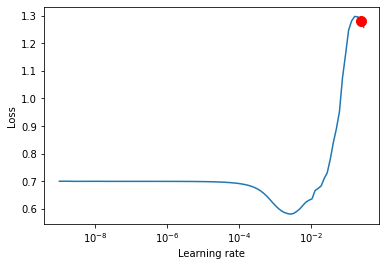

In [ ]:
if do_search:
    # Pick point based on plot, or get suggestion
    best_lr = lr_finder.suggestion()
    print(f'suggest lr={best_lr}')

    # Plot with
    fig = lr_finder.plot(suggest=True)

    logger.experiment.log_figure(figure_name='LR Finder', figure=fig)

    fig

In [ ]:
lr_finder.suggestion(0, 10)

0.0008589836120408862

$\to$ set `lr=[min_lr, max_lr]` for trainig multile layers or `lr=[best_lr]` for just adjusting the `fc`-layer. the max lr should be the steepest point or the lowest point divided by 10. the min lr should not be lower than the first step loss is going down

In [43]:
min_lr = 3e-6 #@param {type:"number"}
max_lr = 3e-3 #@param {type:"number"}

assert min_lr <= max_lr
assert max_lr < 1

module.hparams.lr = [min_lr, max_lr]

module.lrs

array([3.e-03, 3.e-04, 3.e-05, 3.e-06])

## 4. Logging


In [46]:
train_params, total_params = module.count_parameters()
logger.experiment.log_other('total_parameters', total_params)
logger.experiment.log_other('trainable_parameters', train_params)

logger.experiment.log_text(text=str(module.summarize()), metadata={'type': 'summary'})

logger.log_hyperparams(module.hparams)

logger.experiment.log_text(text=str(arch), metadata={'type': 'graph'})

{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=5acddf92177e4a7ebddf2771bfa6b695&experimentKey=ee68cb3f6dd14c66b2c68d1df72a818b',
 'assetId': '5acddf92177e4a7ebddf2771bfa6b695',
 'web': 'https://www.comet.ml/api/asset/download?assetId=5acddf92177e4a7ebddf2771bfa6b695&experimentKey=ee68cb3f6dd14c66b2c68d1df72a818b'}

### log a few data statistics...

In [47]:
eval = EvaluationModule(out_path, dm, logger, img_format='eps')


In [48]:
import torch
annos = torch.sum(torch.tensor([dm.stats[context].actions for context in ['train', 'val']]), dim=0).tolist()
distri = dict(zip(dm.classes, annos))
logger.experiment.log_text(text=distri, metadata={'type': 'classes'})

{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=64462fc6f55c4092b49e8c15c7e9490f&experimentKey=ee68cb3f6dd14c66b2c68d1df72a818b',
 'assetId': '64462fc6f55c4092b49e8c15c7e9490f',
 'web': 'https://www.comet.ml/api/asset/download?assetId=64462fc6f55c4092b49e8c15c7e9490f&experimentKey=ee68cb3f6dd14c66b2c68d1df72a818b'}

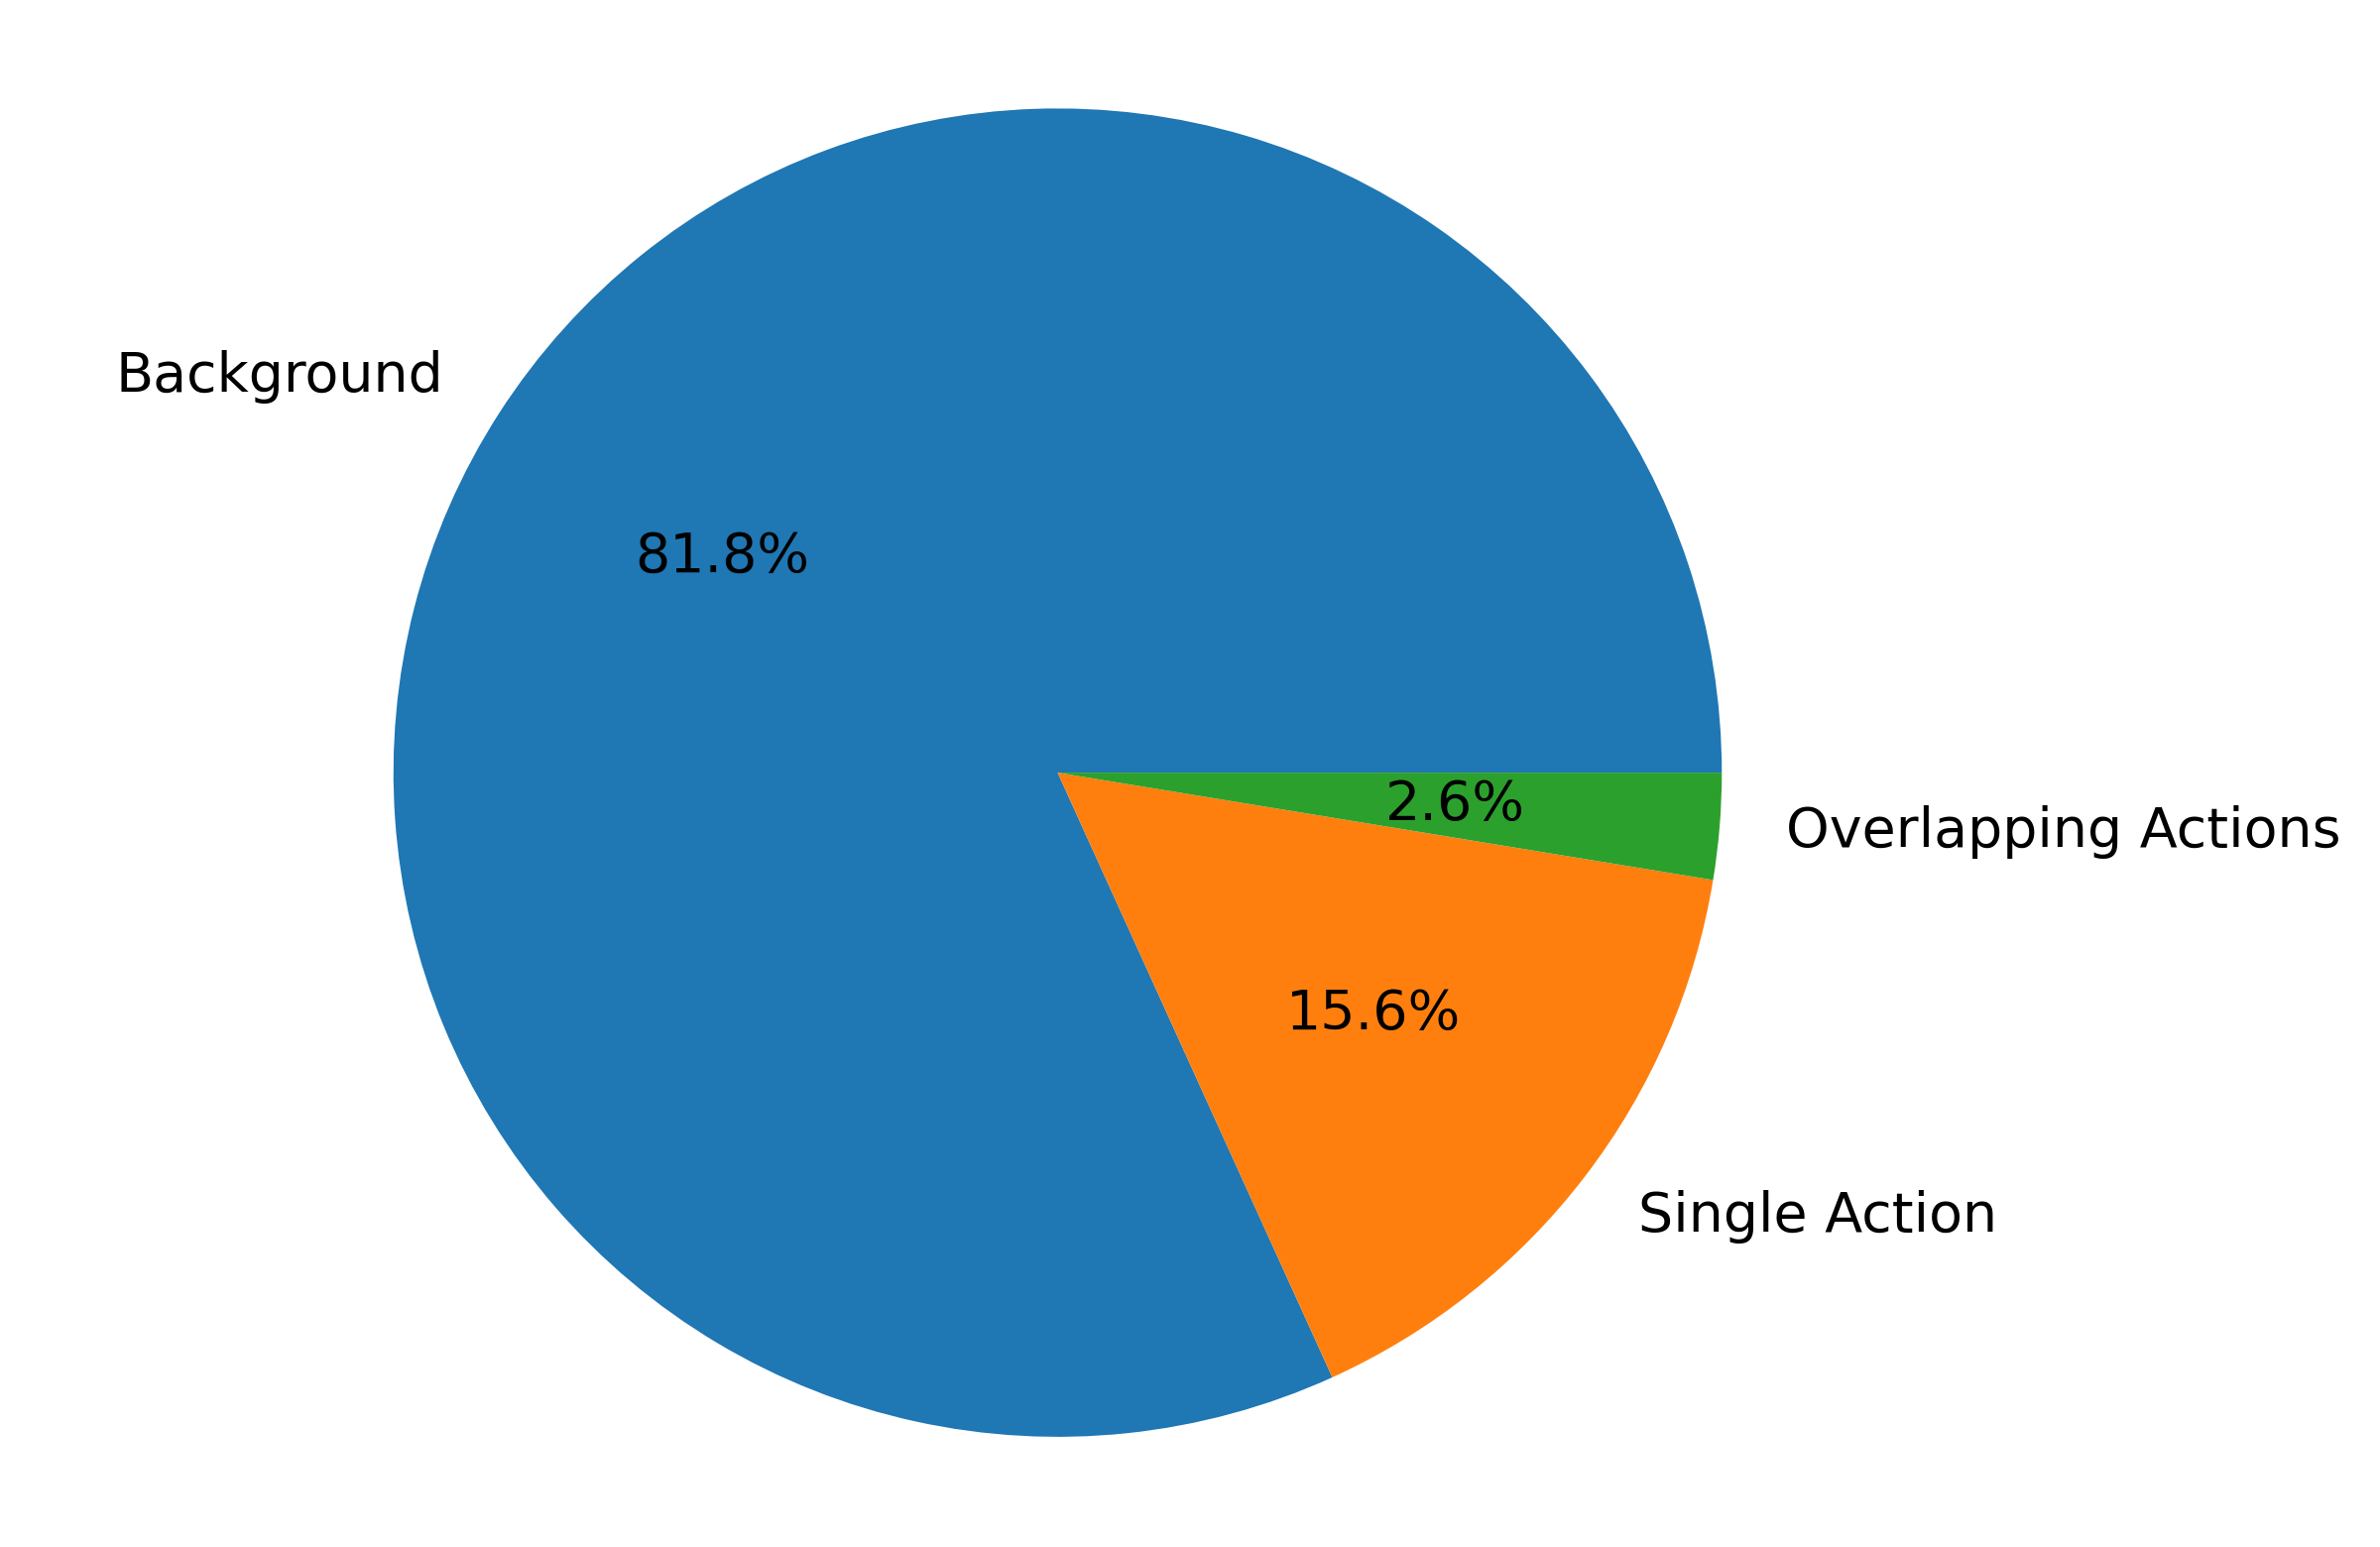

In [49]:
fig = eval.plot_background_ratio(context='train', save=True, upload=True)
fig

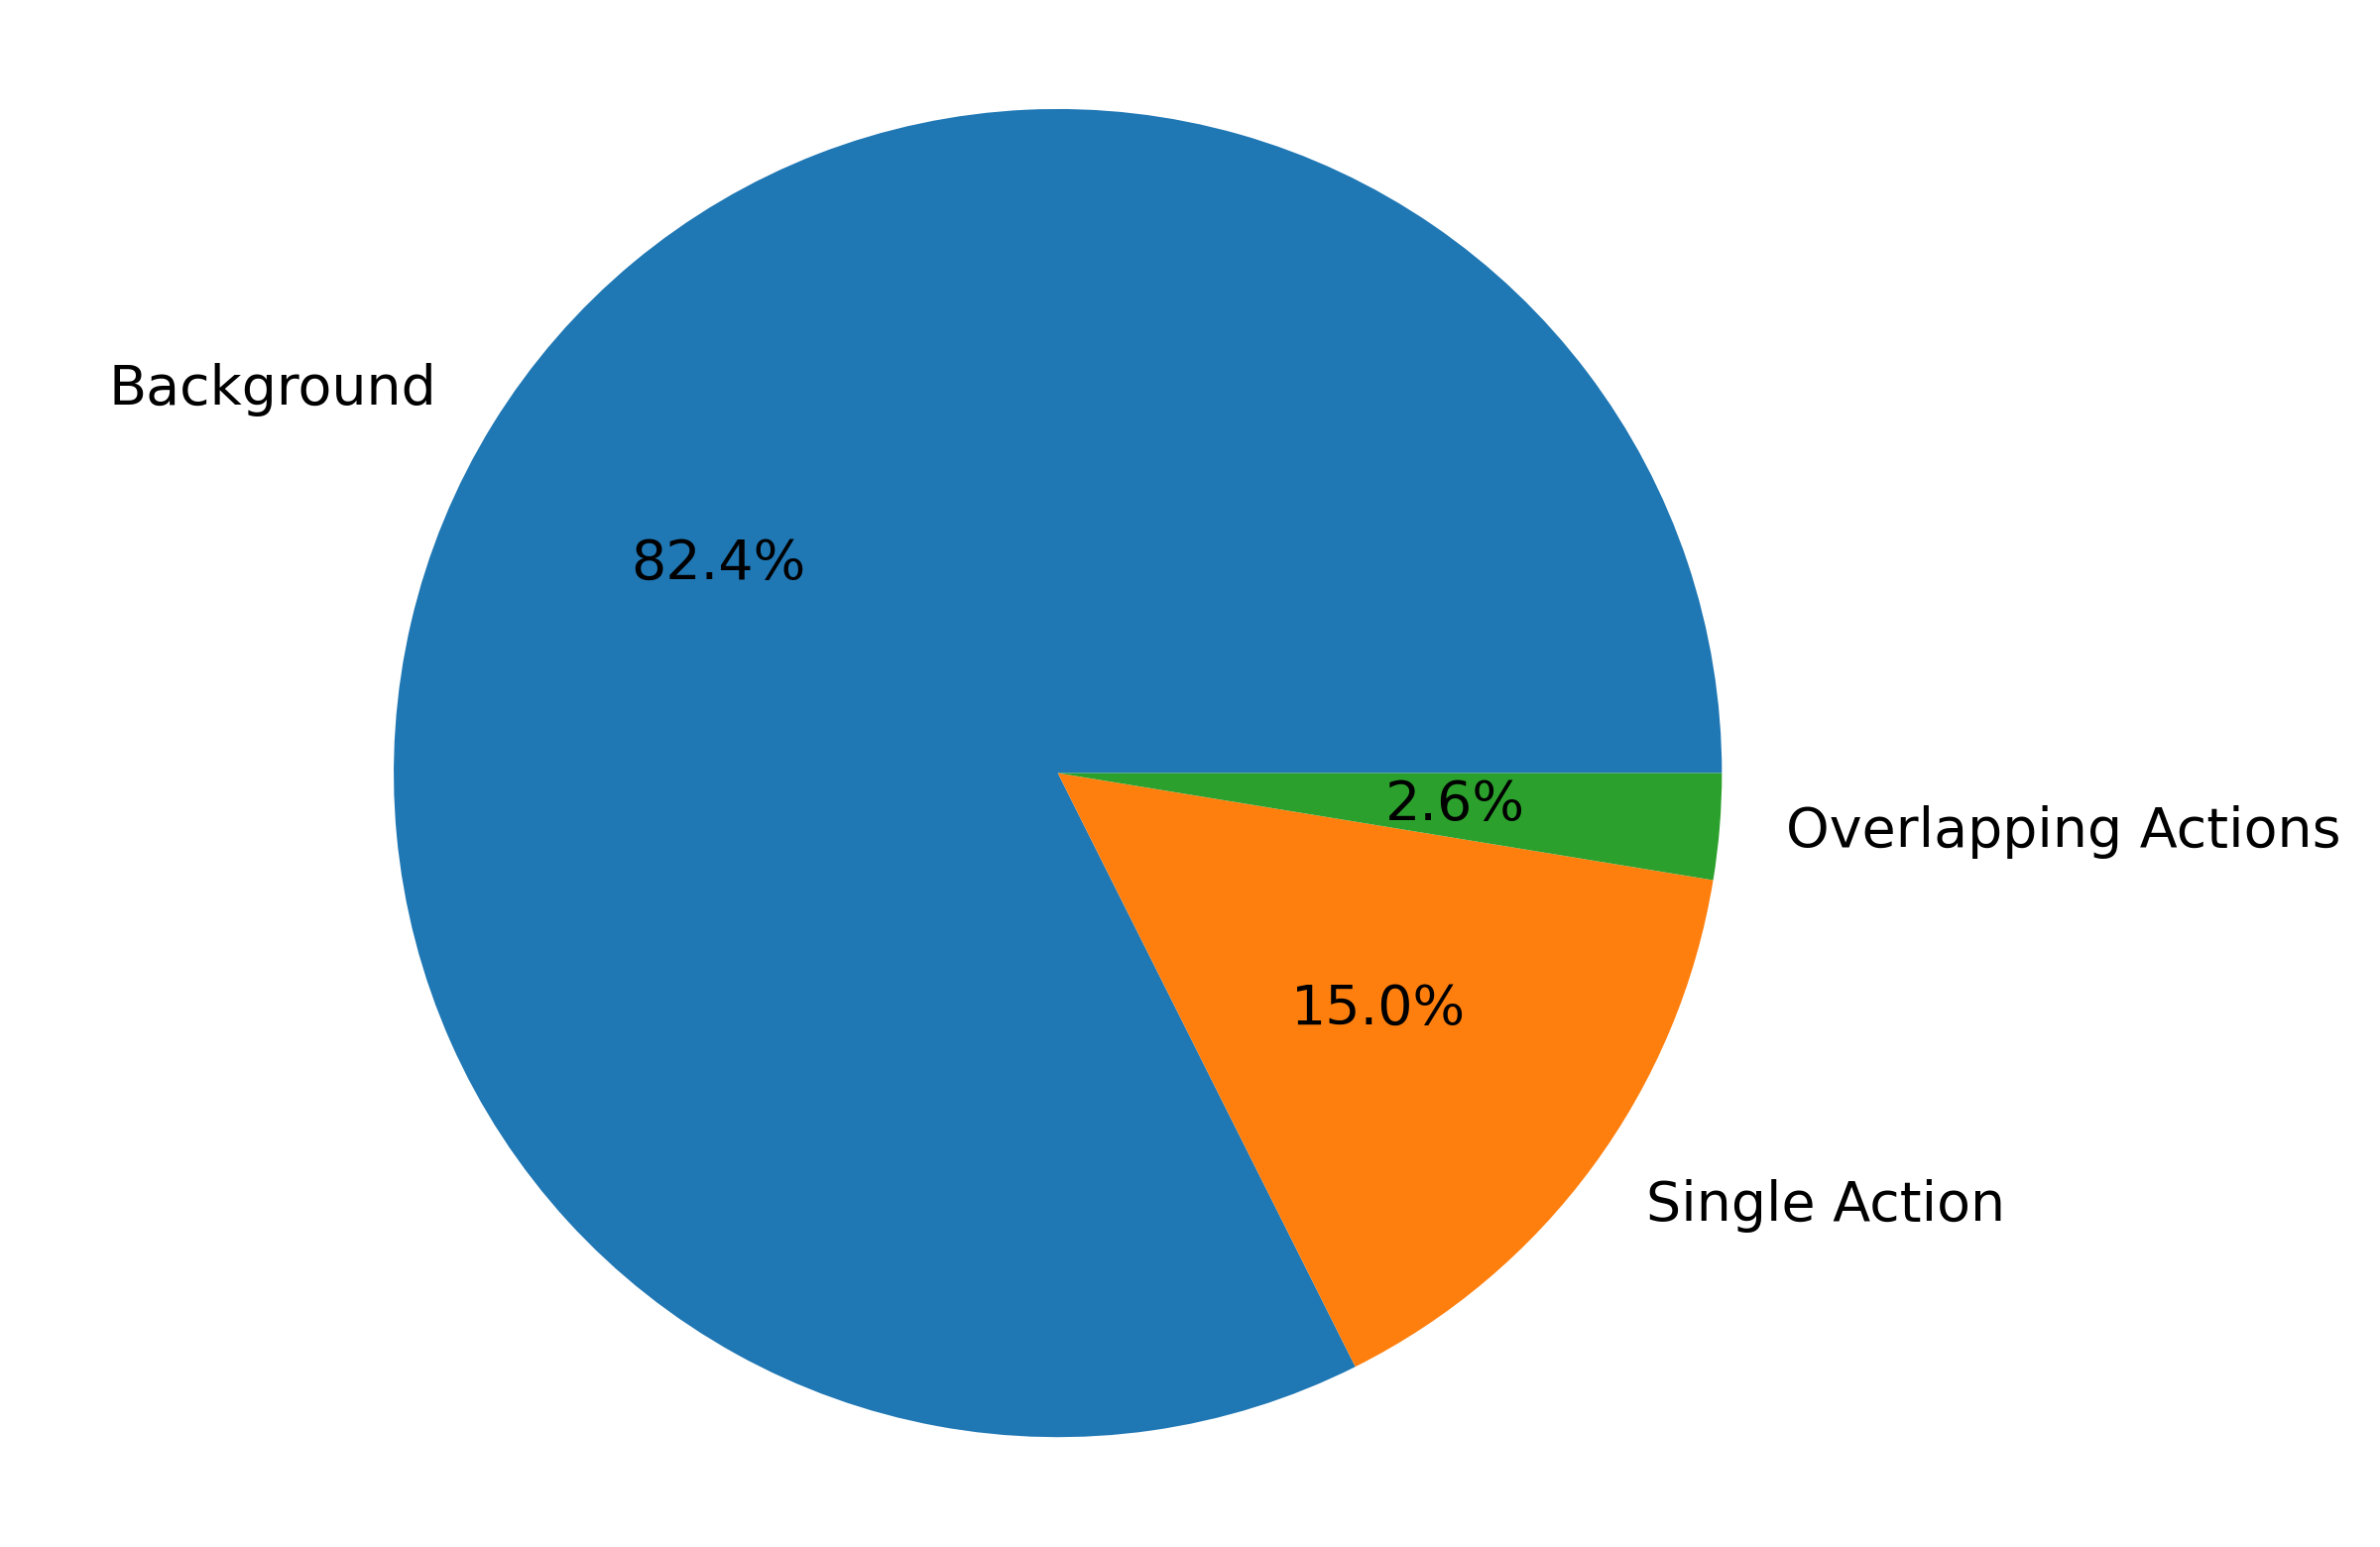

In [50]:
fig = eval.plot_background_ratio(context='val', save=True, upload=True)
fig

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


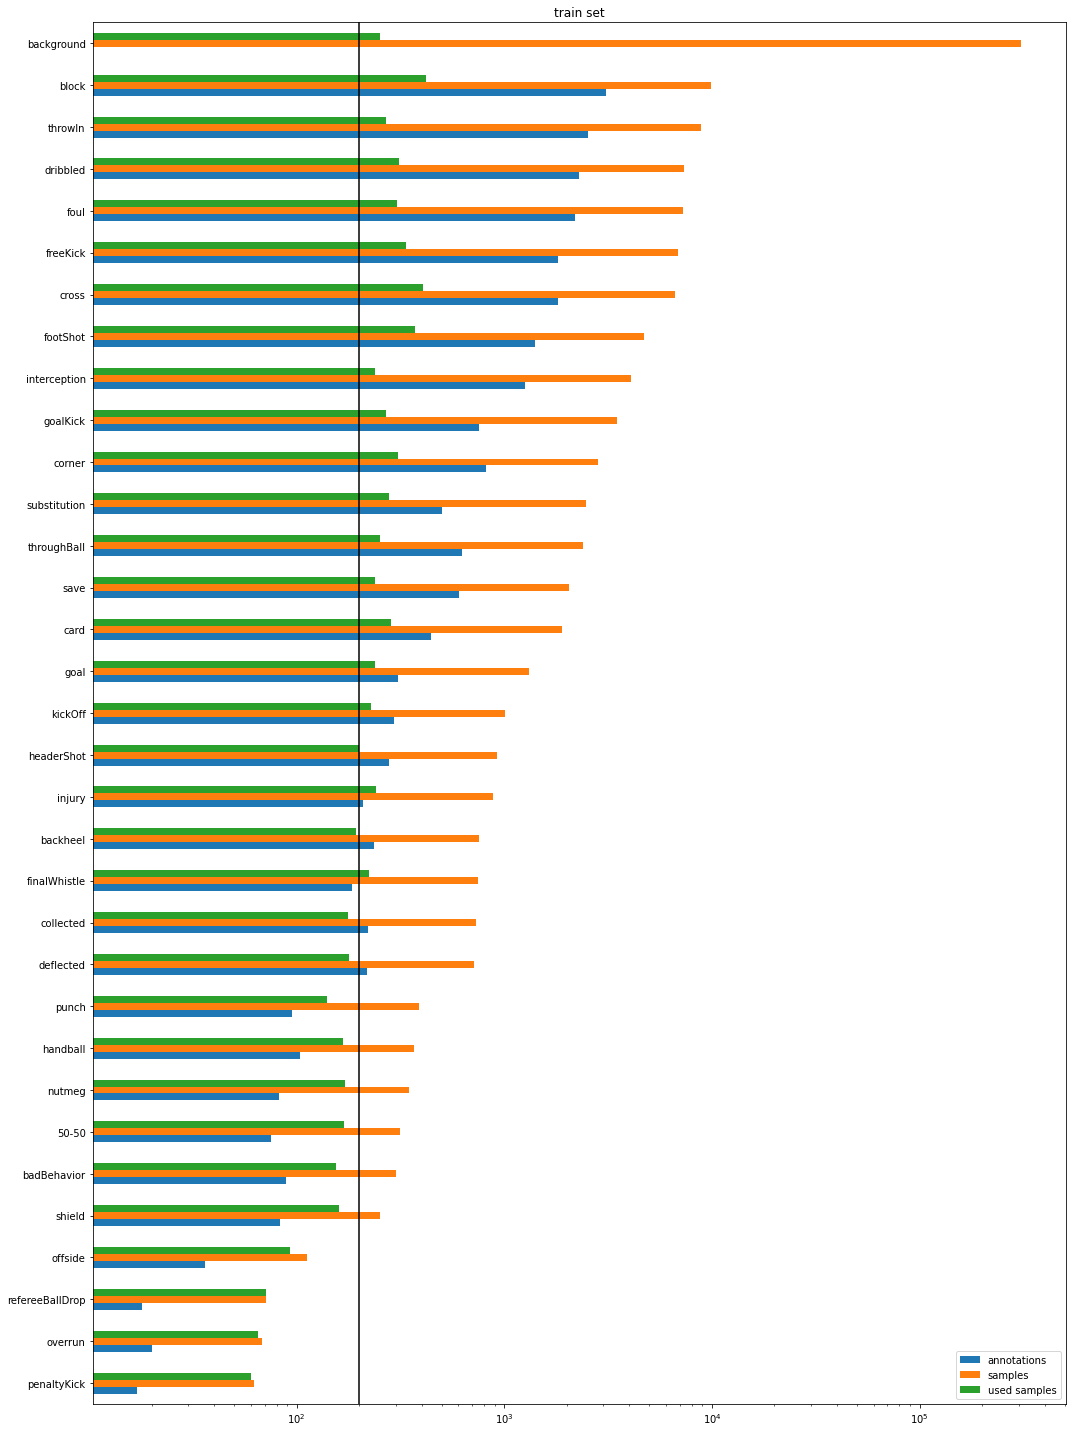

In [51]:
eval.plot_distribution(context='train', save=True, upload=True)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


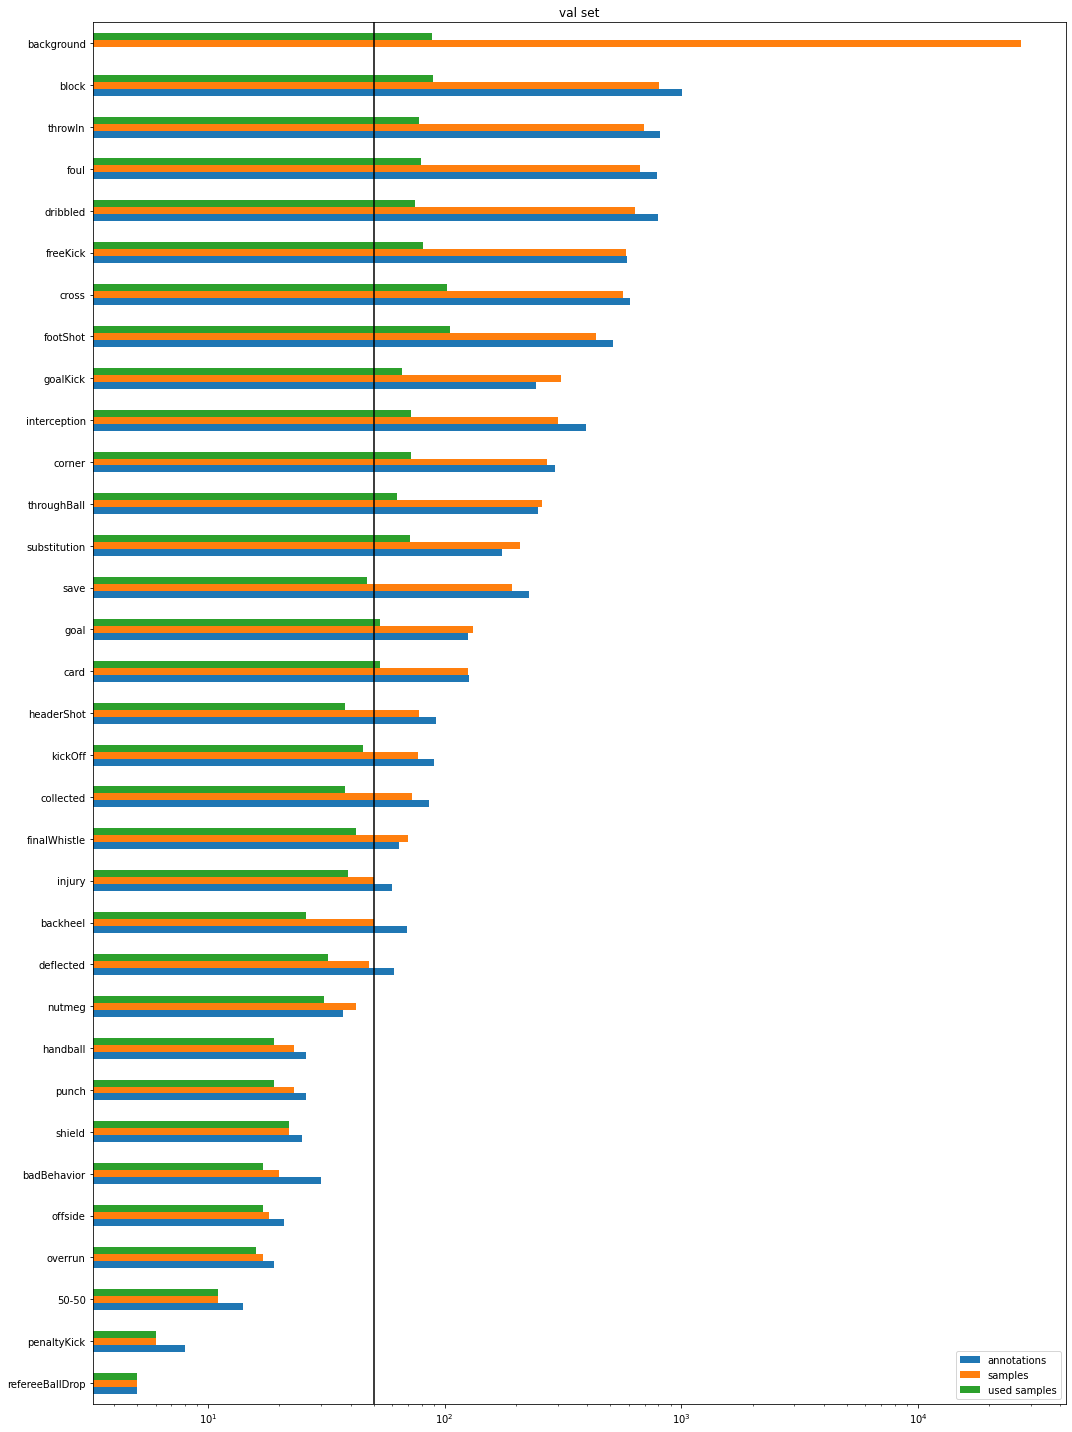

In [52]:
eval.plot_distribution(context='val', save=True, upload=True)


plot a random sample...

In [53]:
plot = eval.get_sample_plot(context='train')

row set to 102117 by random choice


In [54]:
plot.show('sample')

/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."


'<video width="864" height="576" controls autoplay loop>\n  <source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAANDFG1kYXQAAAKuBgX//6rcRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg\nQVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv\neDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9\nMHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm\nPTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6\nb25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r\nYWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj\nZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh\nbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl\naWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz\naD0wIHJjX2xvb2thaGVhZD00MCByYz

In [55]:
plot.save('svg')
plot.save('gif')

/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."


PosixPath('data/out/samples/9783@2:3995.0-3999.0.gif')

In [56]:
plot = eval.get_sample_plot(context='val')

row set to 4556 by random choice


In [57]:
plot.show('sample')

/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."


'<video width="864" height="576" controls autoplay loop>\n  <source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAJ0GG1kYXQAAAKuBgX//6rcRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg\nQVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv\neDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9\nMHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm\nPTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6\nb25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r\nYWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj\nZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh\nbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl\naWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz\naD0wIHJjX2xvb2thaGVhZD00MCByYz

In [58]:
plot.save('svg')
plot.save('gif')

/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."


PosixPath('data/out/samples/70300@1:1156.0-1160.0.gif')

## 5. Train

 * **TODO** eventually re-init classifier if lr monitor grows exponential after lr_find (**if lr_find throws an error, it gets in invalid state**)

In [47]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from src.train.callbacks.reporter import Reporter
from pathlib import Path
import pandas as pd

reporter = Reporter(Path(out_path).joinpath(module.id), dm.classes, df=pd.read_csv(report_path) if new == False else None)
lr_logger = LearningRateMonitor(logging_interval='step')

checkpoints = ModelCheckpoint(monitor='val_auroc_macro',
                              dirpath=str(Path(out_path).joinpath(module.id)),
                              prefix='',
                              save_top_k=3,
                              mode='max',
                              verbose=True)

trainer = Trainer(accumulate_grad_batches=module.accumulate_grad_batches, # active in real life training
                  auto_lr_find=False, # not needed because it is called explicitly
                  #auto_scale_batch_size='power',
                  #benchmark=True, # active in train/val-loops -> will speedup gpu
                  callbacks=[reporter, lr_logger],
                  checkpoint_callback=checkpoints,
                  #fast_dev_run=True,
                  flush_logs_every_n_steps=100,
                  gpus=1,
                  #gradient_clip_val=0.5, # active if gradient vanish or explode
                  #limit_val_batches=10, # active for testing
                  log_every_n_steps=1, # default is 50
                  logger=logger,
                  max_epochs=module.hparams.epochs,
                  #max_steps=30,
                  num_sanity_val_steps=0,  # no test run
                  #overfit_batches=0.01,  # activate for testing
                  precision=precision,
                  #profiler="simple", # active to see bottlenecks
                  #profiler="advanced", # active to see bottlenecks
                  progress_bar_refresh_rate=50,
                  reload_dataloaders_every_epoch=True,
                  resume_from_checkpoint=str(pretrained_path) if not new else None,
                  #tpu_cores=1,
                  #track_grad_norm=2, # -1,  # 2
                  weights_summary='top',
                  #working_dir=Path('dist'),
                  )


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


In [49]:
trainer.callbacks

In [ ]:
#x3d: module.hparams.scheduler = 'plateau'

In [63]:
from pytorch_lightning import seed_everything

seed_everything(21012021)

21012021

In [ ]:
dm.batch_size = module.train_bs
trainer.fit(module, datamodule=dm)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/narendorf/soccar-32-ph1/a009a640232646bc970d832bbf1a8063



sample 6176.0/459244 random clips


/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dis

upload best checkpoints...

In [ ]:
f'best checkpoints at {checkpoints.best_model_path}'

In [66]:
ckpt_path = Path(checkpoints.best_model_path)
res = logger.experiment.log_asset(ckpt_path)
res

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/narendorf/soccar-32-ph1/ee68cb3f6dd14c66b2c68d1df72a818b



{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=570050eb6fef4fb58a9c54cc6a8697a7&experimentKey=ee68cb3f6dd14c66b2c68d1df72a818b',
 'assetId': '570050eb6fef4fb58a9c54cc6a8697a7',
 'web': 'https://www.comet.ml/api/asset/download?assetId=570050eb6fef4fb58a9c54cc6a8697a7&experimentKey=ee68cb3f6dd14c66b2c68d1df72a818b'}

upload report...

In [67]:
report_path = reporter.report_file
f'saved report at {report_path}'

'saved report at data/out/report.csv'

In [68]:
res = logger.experiment.log_asset(report_path)
res

TypeError: ignored

## 6. Test

 * **TODO**: Test Max vs Avg Score Aggregation


### Get data

index test data...

In [69]:
dm.setup('test')

collecting samples



sample 2214/14084 clips


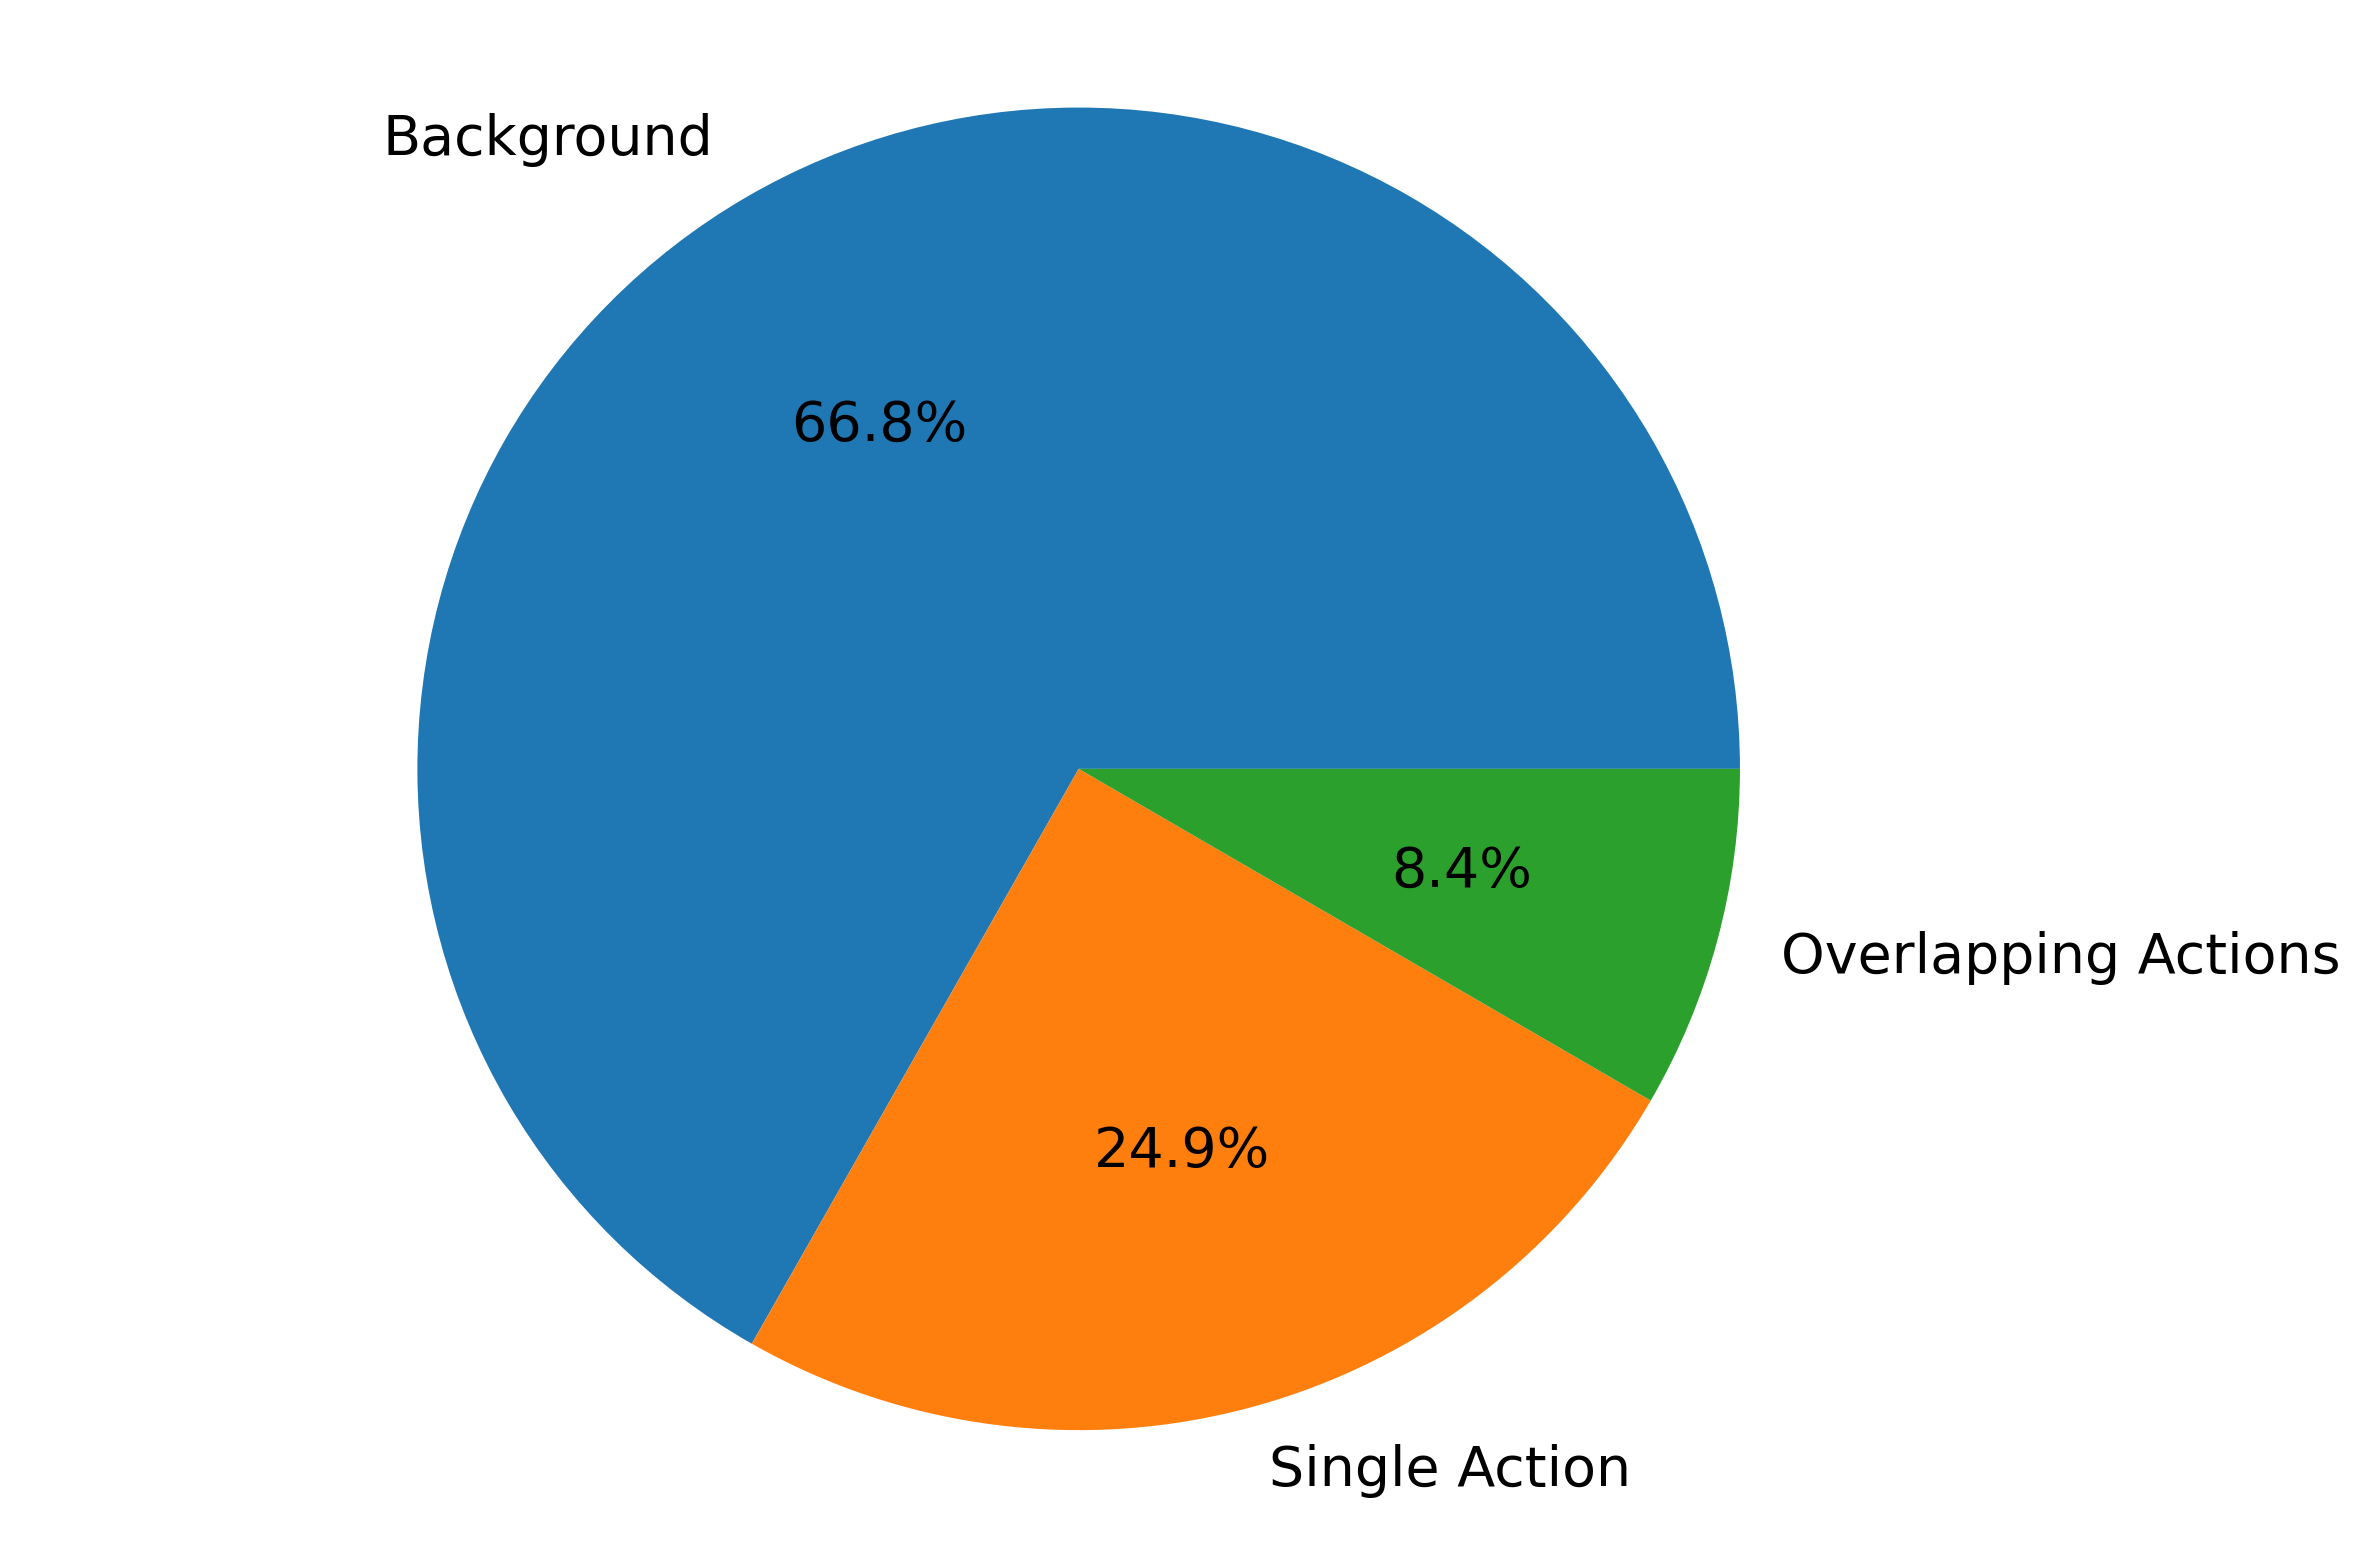

In [70]:
fig = eval.plot_background_ratio(context='test', save=True, upload=True)
fig

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


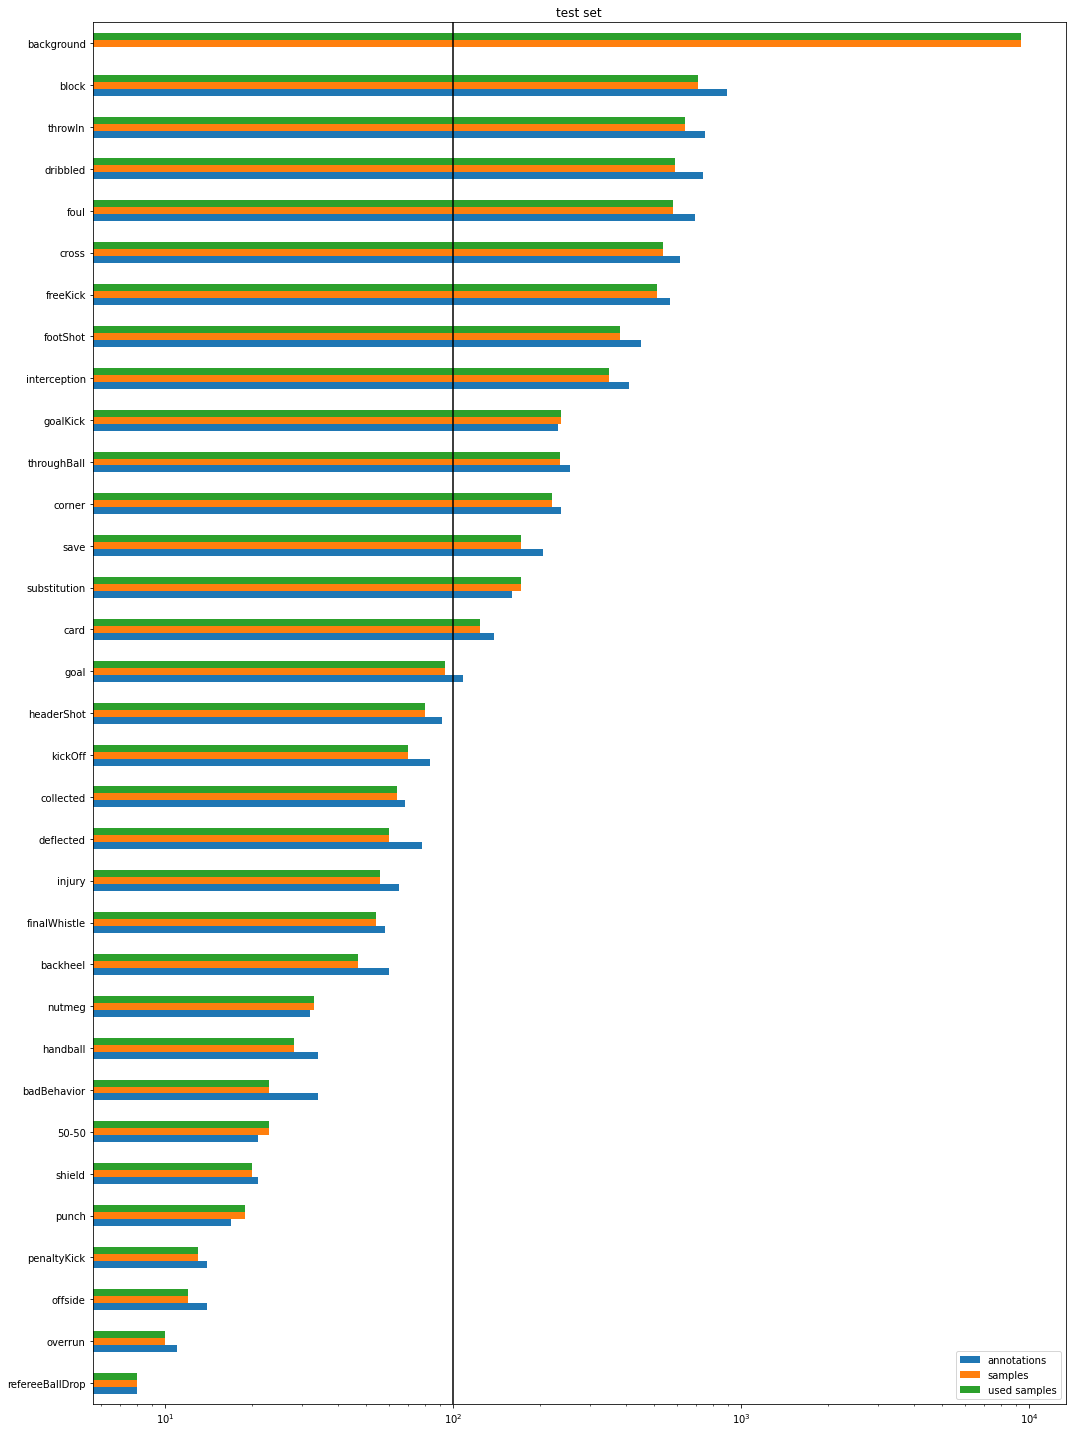

In [71]:
eval.plot_distribution(context='test', save=True, upload=True)

In [ ]:
plot = eval.get_sample_plot(context='test')

row set to 3161 by random choice


In [ ]:
from ipywidgets import HTML
HTML(plot.show('sample'))

/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."


HTML(value='<video width="864" height="576" controls autoplay loop>\n  <source type="video/mp4" src="data:vide…

In [ ]:
plot.save('svg')
plot.save('gif')

/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."


PosixPath('data/out/samples/265857@2:3680.0-3690.0.gif')

### Run evaluation

get max batch size on 5 views per sample ...

try avg and max consensus...

In [ ]:
module.hparams.consensus = 'max'
dm.batch_size = module.test_bs
trainer.test(module, dm.test_dataloader())

/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dis

upload report...

In [ ]:
report_path = reporter.report_file
f'saved report at {report_path}'

In [ ]:
res = logger.experiment.log_asset(report_path, overwrite=True)
res

## 7. Report Evaluation

In [ ]:
from src.eval import ReportEvaluationModule
import pandas as pd
df = pd.read_csv(report_path)
eval = ReportEvaluationModule(out_path, dm, df, logger, consensus='max')

In [ ]:
f'got report containing {eval.num_epochs} epochs and {eval.num_test_runs} tests (epoch={eval.last_test_epoch})'

In [ ]:
assert eval.integrity_check()

In [ ]:
df = eval.report

In [ ]:
fig = eval.train_samples_boxplot(True, True)
fig

In [ ]:
eval.get_scalars(save=True, upload=True)

In [ ]:
eval.get_scalar_by_class('test', 'auroc', save=True, upload=True)

In [ ]:
eval.get_curve(split='test', metric='roc', reductions=['micro', 'macro'], classes=['foul', 'card', 'freeKick', 'substitution', 'cross', 'save', 'corner', 'goal'], save=True, upload=True)

In [ ]:
eval.get_scalar_by_class('test', 'balanced_accuracy', save=True, upload=True)

In [ ]:
eval.get_scalar_by_class('test', 'recall', save=True, upload=True)

In [ ]:
eval.get_scalar_by_class('test', 'precision', save=True, upload=True)

In [ ]:
eval.get_scalar_by_class('test', 'f1', save=True, upload=True)

In [ ]:
eval.get_threshold_by_metric('test', 'balanced_accuracy', 'weighted', save=True, upload=True)

In [ ]:
eval.get_threshold_by_metric('test', 'f1', 'weighted', save=True, upload=True)

optional: test again with avg predictions

In [ ]:
module.hparams.consensus = 'avg'
dm.batch_size = module.test_bs
trainer.test(module, dm.test_dataloader())

In [ ]:
res = logger.experiment.log_asset(report_path, overwrite=True)
res

In [ ]:
eval.get_metrics_by_consensus(True, True)